In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = "white"

import data.data as data
import data.acf as acf
import error.error as error
import reservoir.reservoir as res

$$
\mathbf{r}_{t+1} = \tanh(\mathbf{A}\mathbf{r}_t + W_{\text{in}}\mathbf{u}_t)
$$
- $\mathbf{u}_t = (x_t, y_t, z_t)$ denotes the state of L-63 trajectory at time $t$. 
- $A \in \reals^{R \times R}$, with elements from Uniform(0, 1). Then scaled so 
that its spectral radius is <= `RHO`.
- $W_{\text{in}} \in \reals^{R \times D}$, with elements from Uniform($-\sigma$, $\sigma$). 

$R$ denotes the number of reservoir nodes. 

$\beta$ denotes the size of penalty in Tikonov regression. 

In [3]:
LORENZ_LYAPUNOV = 0.91
RHO = 0.6
S_IN = 1
R = 500
BETA = 10e-4

Generate training data

In [4]:
del_t = 0.02
u_train = data.generate_lorenz_63(del_t=del_t, steps=10000, washout=9500)
T = u_train.shape[0]
time = np.arange(T) * del_t * LORENZ_LYAPUNOV

Text(0, 0.5, 'Phase Space')

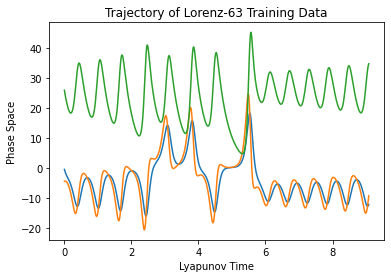

In [5]:
plt.plot(time, u_train[:, 0], label="x")
plt.plot(time, u_train[:, 1], label="y")
plt.plot(time, u_train[:, 2], label="z")
plt.title("Trajectory of Lorenz-63 Training Data")

plt.xlabel("Lyapunov Time")
plt.ylabel("Phase Space")

Text(0, 0.5, 'Autocorrelation')

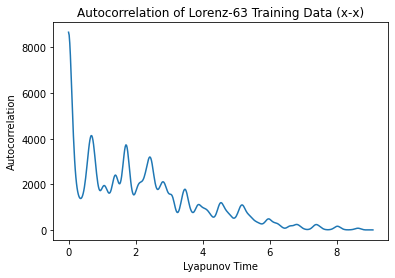

In [6]:
acfs_train = acf.compute_acfs(u_train, "x", "x")
plt.figure(facecolor="white")
plt.plot(time, acfs_train)
plt.title("Autocorrelation of Lorenz-63 Training Data (x-x)")
plt.xlabel("Lyapunov Time")
plt.ylabel("Autocorrelation")

Train $W_{\text{out}}$ on `u_train`.

In [7]:
seed = 1
W_out, r_train, A, W_in = res.train_p(u_train, rho=RHO, s_in=S_IN, R=R, beta=BETA, seed=seed)

/Users/leoli/Desktop/uni/Honours/thesis-code/reservoir/reservoir.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  r[t] = next_res(


In [8]:
train_preds = res.predict(u_train[0], p=W_out, T=T, A=A, W_in=W_in)

/Users/leoli/Desktop/uni/Honours/thesis-code/reservoir/reservoir.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  u_hat[t] = W_out(curr_res, p)


Text(0, 0.5, 'Phase Space')

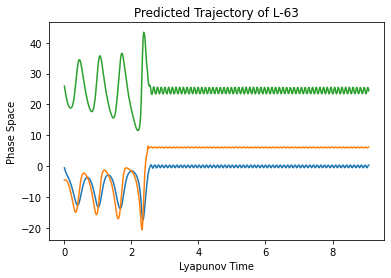

In [9]:
plt.plot(time, train_preds[:, 0], label="x")
plt.plot(time, train_preds[:, 1], label="y")
plt.plot(time, train_preds[:, 2], label="z")
plt.title("Predicted Trajectory of L-63")
plt.xlabel("Lyapunov Time")
plt.ylabel("Phase Space")

Accuracy of predicted trajectory given same initial condition (in-sample). Only 
show $x$ domain. 

In [10]:
error.RMSE(u_train, train_preds)

array([ 6.84844304, 10.64435978,  7.39483247])

Text(0, 0.5, 'Phase Space')

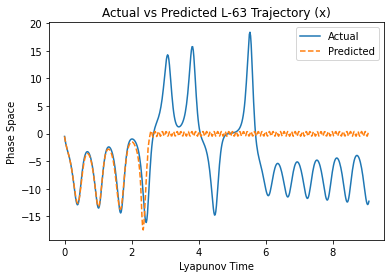

In [11]:
plt.figure(facecolor="white")
plt.plot(time, u_train[:, 0], label="Actual")
plt.plot(time, train_preds[:, 0], label="Predicted", linestyle="dashed")

plt.legend()

plt.title("Actual vs Predicted L-63 Trajectory (x)")

plt.xlabel("Lyapunov Time")
plt.ylabel("Phase Space")

Use the same reservoir construction (`A`, `W_in`, `W_out`) to predict other 
initial conditions

In [12]:
u_test = data.generate_lorenz_63(initial_state=[-1, 2, -1.5], del_t=del_t, steps=10000, washout=9500)
T_test = u_test.shape[0]
time_test = np.arange(T_test) * del_t * LORENZ_LYAPUNOV

In [13]:
test_preds = res.predict(u_test[0], p=W_out, T=T_test, A=A, W_in=W_in)

/Users/leoli/Desktop/uni/Honours/thesis-code/reservoir/reservoir.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  u_hat[t] = W_out(curr_res, p)


In [14]:
error.RMSE(u_test, test_preds)

array([ 7.27084721, 11.90091204,  8.18988204])

Text(0, 0.5, 'Phase Space')

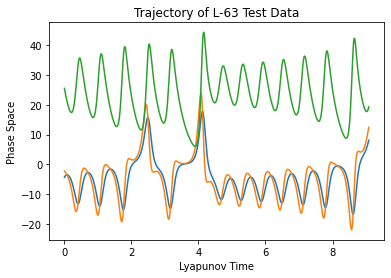

In [26]:
plt.plot(time, u_test[:, 0], label="x")
plt.plot(time, u_test[:, 1], label="y")
plt.plot(time, u_test[:, 2], label="z")
plt.title("Trajectory of L-63 Test Data")
plt.xlabel("Lyapunov Time")
plt.ylabel("Phase Space")

Text(0, 0.5, 'Phase Space')

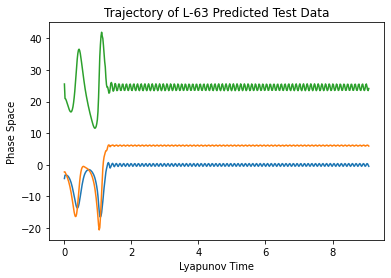

In [16]:
plt.figure(facecolor="white")
plt.plot(time, test_preds[:, 0], label="x")
plt.plot(time, test_preds[:, 1], label="y")
plt.plot(time, test_preds[:, 2], label="z")
plt.title("Trajectory of L-63 Predicted Test Data")
plt.xlabel("Lyapunov Time")
plt.ylabel("Phase Space")

Text(0, 0.5, 'Phase Space')

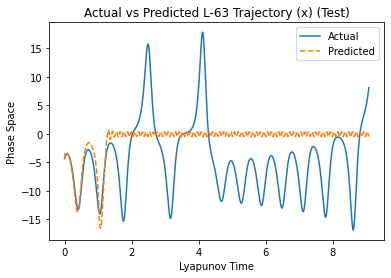

In [17]:
plt.figure(facecolor="white")
plt.plot(time, u_test[:, 0], label="Actual")
plt.plot(time, test_preds[:, 0], label="Predicted", linestyle="dashed")

plt.legend()

plt.title("Actual vs Predicted L-63 Trajectory (x) (Test)")

plt.xlabel("Lyapunov Time")
plt.ylabel("Phase Space")

What happens for a lot of different initial conditions?

In [18]:
seeds = np.arange(100, 200)
N = 100

In [19]:
initial_states = []
for i in range(N):
    random_state = np.random.RandomState(seeds[i])
    ic = list(random_state.rand(3))
    initial_states.append(ic)

In [20]:
test_data = []
reservoirs = []
predicted_data = []
count=1
for ic in initial_states:
    u = data.generate_lorenz_63(initial_state=ic, del_t=del_t, steps=10000, washout=9500)
    T = u.shape[0]
    preds, rc = res.predict(u[0], p=W_out, T=T, A=A, W_in=W_in, full=True)

    test_data.append(u)
    reservoirs.append(rc)
    predicted_data.append(preds)

    print("{} / {} done.".format(count, N))
    count += 1

/Users/leoli/Desktop/uni/Honours/thesis-code/reservoir/reservoir.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  u_hat[t] = W_out(curr_res, p)


1 / 100 done.
2 / 100 done.
3 / 100 done.
4 / 100 done.
5 / 100 done.
6 / 100 done.
7 / 100 done.
8 / 100 done.
9 / 100 done.
10 / 100 done.
11 / 100 done.
12 / 100 done.
13 / 100 done.
14 / 100 done.
15 / 100 done.
16 / 100 done.
17 / 100 done.
18 / 100 done.
19 / 100 done.
20 / 100 done.
21 / 100 done.
22 / 100 done.
23 / 100 done.
24 / 100 done.
25 / 100 done.
26 / 100 done.
27 / 100 done.
28 / 100 done.
29 / 100 done.
30 / 100 done.
31 / 100 done.
32 / 100 done.
33 / 100 done.
34 / 100 done.
35 / 100 done.
36 / 100 done.
37 / 100 done.
38 / 100 done.
39 / 100 done.
40 / 100 done.
41 / 100 done.
42 / 100 done.
43 / 100 done.
44 / 100 done.
45 / 100 done.
46 / 100 done.
47 / 100 done.
48 / 100 done.
49 / 100 done.
50 / 100 done.
51 / 100 done.
52 / 100 done.
53 / 100 done.
54 / 100 done.
55 / 100 done.
56 / 100 done.
57 / 100 done.
58 / 100 done.
59 / 100 done.
60 / 100 done.
61 / 100 done.
62 / 100 done.
63 / 100 done.
64 / 100 done.
65 / 100 done.
66 / 100 done.
67 / 100 done.
68 /

In [23]:
test_errors = [
    error.RMSE(test_data[i], test_preds[i]) for i in range(len(test_data))
]
test_errors = pd.DataFrame(np.array(test_errors))
test_errors.columns = ["x", "y", "z"]

In [24]:
test_errors

,x,y,z
0,8.618380,9.136493,9.146510
1,8.690741,9.484461,9.679376
2,6.510529,7.629952,8.150080
3,8.301611,9.396913,9.243861
4,7.043560,8.204785,9.490198
...,...,...,...
95,8.004415,11.019170,8.744906
96,8.012819,9.205747,8.749181
97,7.791879,7.442366,8.274951
98,7.856110,10.385830,8.805543


(array([38., 19., 14.,  3.,  7., 10.,  3.,  2.,  2.,  2.]),
 array([ 7.96570639,  9.13786272, 10.31001905, 11.48217539, 12.65433172,
        13.82648806, 14.99864439, 16.17080073, 17.34295706, 18.5151134 ,
        19.68726973]),
 <BarContainer object of 10 artists>)

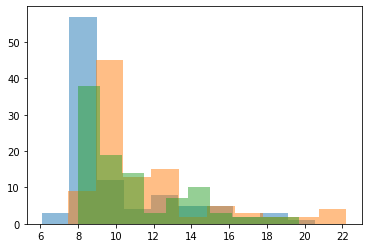

In [30]:
plt.hist(test_errors["x"], alpha=0.5)
plt.hist(test_errors["y"], alpha=0.5)
plt.hist(test_errors["z"], alpha=0.5)